In [1]:
import pandas as pd
from hkfold import HKFold
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from keras.layers import PReLU
from sklearn.utils import shuffle
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dframe_path = 'data/cabauw/processed.csv.gz'

try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')


df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
df = df[df.ds != 201603]
df = df.dropna()

In [4]:
features = [
    'dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain',
    'temp', 'soil_temp', 'z', 'air_dens', 'virtual_temp',
    'wind',
    'ustar', 'H', 'LE', 'zL', 'lval'
]

target = 'phi_m'

test_ds = np.random.choice(df.ds.unique(), 12, replace=False)
test_mask = df.ds.isin(test_ds)
train_x, train_y = df[~test_mask][features], df[~test_mask][target]
test_x, test_y = df[test_mask][features], df[test_mask][target]
print('training with %d, testing with %d' % (len(train_x), len(test_x)))

training with 1249794, testing with 80298


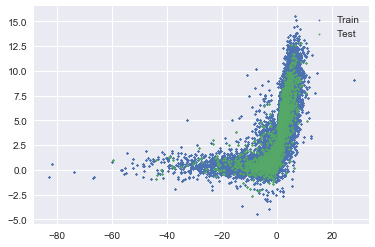

In [5]:
plt.scatter(df[~df.ds.isin(test_ds)].zL, df[~df.ds.isin(test_ds)].phi_m, s=2, label='Train')
plt.scatter(df[df.ds.isin(test_ds)].zL, df[df.ds.isin(test_ds)].phi_m, s=2, label='Test')
plt.legend()
plt.show()

In [6]:
mean_x, mean_y = train_x.mean(), train_y.mean()
std_x, std_y = train_x.std(), train_y.std()

train_x = (train_x - mean_x) /  std_x
test_x = (test_x - mean_x) / std_x

train_y = (train_y - mean_y) / std_y
test_y = (test_y - mean_y) / std_y

In [6]:
model = Sequential([
    Dense(1024, input_shape=(len(features),)), PReLU(),
    Dense(1024), PReLU(),
    Dense(256), PReLU(),
    Dense(256), PReLU(),
    Dense(128), PReLU(),
    Dense(128), PReLU(),
    Dense(32), PReLU(),
    Dense(1)
])

opt = RMSprop(lr=0.001)
model.compile(loss='mse', optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              17408     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 1024)              1024      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 1024)              1024      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 256)               256       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
__________

In [8]:
from sklearn.utils import shuffle
train_x, train_y = shuffle(train_x, train_y)

hist = model.fit(
    train_x, train_y,
    batch_size=2048, epochs=20,
    shuffle=True,
    callbacks=[
        ReduceLROnPlateau(factor=0.2, verbose=1, min_lr=1e-6),
        ModelCheckpoint('dev/models/weights-w.{epoch:04d}-{val_loss:.4f}.hdf5',
                        verbose=1, save_best_only=True),
        TensorBoard('dev/logs/', write_graph=False, write_grads=True),
        EarlyStopping(min_delta=0.0001, patience=50),
    ],
    validation_data=(test_x, test_y)
    #validation_split=0.2
)

Train on 1310454 samples, validate on 19638 samples
Epoch 1/20
1308672/1310454 [============================>.] - ETA: 0s - loss: 0.9466
Epoch 00001: val_loss improved from inf to 0.52013, saving model to dev/models/weights-w.0001-0.5201.hdf5
1310454/1310454 [==============================] - 25s 19us/step - loss: 0.9460 - val_loss: 0.5201
Epoch 2/20
1308672/1310454 [============================>.] - ETA: 0s - loss: 0.4973
Epoch 00002: val_loss did not improve
1310454/1310454 [==============================] - 27s 20us/step - loss: 0.4972 - val_loss: 0.8217
Epoch 3/20
1306624/1310454 [============================>.] - ETA: 0s - loss: 0.4208
Epoch 00003: val_loss did not improve
1310454/1310454 [==============================] - 26s 20us/step - loss: 0.4205 - val_loss: 0.5470
Epoch 4/20
1306624/1310454 [============================>.] - ETA: 0s - loss: 0.3698
Epoch 00004: val_loss did not improve
1310454/1310454 [==============================] - 27s 21us/step - loss: 0.3695 - val_loss:

KeyboardInterrupt: 

In [10]:
res = {}
for i in range(10):
    test_ds = np.random.choice(df.ds.unique(), 1, replace=False)
    test_mask = df.ds.isin(test_ds)
    train_x, train_y = df[~test_mask][features], df[~test_mask][target]
    test_x, test_y = df[test_mask][features], df[test_mask][target]
    train_x, train_y = shuffle(train_x, train_y)
    
    print('testing with dataset', test_ds)

    model = Sequential([
        Dense(1024, input_shape=(len(features),)), PReLU(),
        Dense(1024), PReLU(),
        Dense(256), PReLU(),
        Dense(256), PReLU(),
        Dense(128), PReLU(),
        Dense(128), PReLU(),
        Dense(32), PReLU(),
        Dense(1)
    ])

    opt = RMSprop(lr=0.001)
    model.compile(loss='mse', optimizer=opt)
    
    hist = model.fit(
        train_x, train_y,
        batch_size=2048, epochs=20,
        shuffle=True,
        verbose=0,
        validation_data=(test_x, test_y)
    )
    
    print('last val loss', hist.history['val_loss'][-1])
    res[i] = {'ds': test_ds, 'hist': hist}

testing with dataset [200703]
last val loss 0.6514049975343207
testing with dataset [200404]
last val loss 0.8330050340766308
testing with dataset [200401]
last val loss 1.6473073969392282
testing with dataset [201203]
last val loss 3.6176841185924196
testing with dataset [200702]
last val loss 7.515175348812337
testing with dataset [201204]
last val loss 2.260379417719546
testing with dataset [201003]
last val loss 1.185254869870861
testing with dataset [200909]
last val loss 1.230241741441127
testing with dataset [201101]


KeyboardInterrupt: 

In [ ]:
for dd, hh in res.items():
    #plt.plot(hh['hist'].history['loss'], '--')
    plt.plot(hh['hist'].history['val_loss'])


plt.ylim(0, 2)
plt.show()